In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from collections import Counter
import numpy as np
import numpy.linalg as LA
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
#import geoplot as gplt
import glob
import datetime as dt
import random
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [22]:
class flussi():
    impianti_file = 'impianti.csv'
    impianti_df = pd.read_csv(impianti_file).drop('Note', axis = 1)
    geo_start = gpd.points_from_xy(impianti_df['Latitude Start'], impianti_df['Longitude Start'])
    geo_end = gpd.points_from_xy(impianti_df['Latitude Start'], impianti_df['Longitude Start'])
    
    impianti_df = gpd.GeoDataFrame(impianti_df)

    impianti_df['GEO_START'] = geo_start
    impianti_df['GEO_END'] = geo_end
    
    impianto_line = gpd.GeoSeries(impianti_df.apply(lambda row: LineString([row['GEO_START'], row['GEO_END']]), axis=1))
    impianti_df['IMPIANTO_LINE'] = impianto_line

    
    def __init__(self, input_file, fast = False):
        '''Carica il file dei dati ed estrae le quantita di interesse'''
        self.file_name = input_file.split('/')[-1][0:-4]
        self.impianti = self.file_name[11:]
        self.date = self.file_name[0:10]
        self.year = self.date[-4:]
        self.month = self.date[3:5]
        self.day = self.date[:2]
        
        if VERBOSE > 0:
            print('starting read_csv')
        try:
            self.df = pd.read_csv(input_file)
        except:
            try:
                self.df = pd.read_excel(input_file)
                print(set(self.df['IMPIANTO']))
                self.df.rename({'IMPIANTO':'ID_IMPIANTO'}, axis = 1, inplace = True)
            except:
                print(Exception('Input must be csv or Excel file.'))
        if VERBOSE > 0:
            print('finished read_csv')

        self.df['DATA_ORA'] = pd.to_datetime(self.df['DATA_ORA'], format = "%d/%m/%Y %H.%M.%S")
            
        self.N = len(self.df)
        
        self.df = pd.merge(self.df, flussi.impianti_df, left_on = 'ID_IMPIANTO', right_on = 'Codice')
        
        if VERBOSE > 0:
            print('finished added lift names')

        geo_start = gpd.points_from_xy(self.df['Latitude Start'], self.df['Longitude Start'])
        geo_end = gpd.points_from_xy(self.df['Latitude End'], self.df['Longitude End'])
        self.df = gpd.GeoDataFrame(self.df)
        self.df['GEO START'] = geo_start
        self.df['GEO END'] = geo_end

        if VERBOSE > 0:
            print('finished adding geodata')
        
        if VERBOSE>2:
            print(f'\n Caricato: {self.file_name}. Esempio record prima risalita:')
            print(self.df.loc[0])
        
        self.cassa = self.df['CASSA']
        self.cassa_set = list(set(self.cassa))
        self.N_casse = len(self.cassa_set)
        self.cassa_counter = Counter(self.cassa)

        if VERBOSE > 0:
            print('finished cassa')
        
        # la serie e' la ID dello sciatore
        self.serie = self.df['SERIE']
        self.serie_set = list(set(self.serie))
        self.serie_counter = Counter(self.serie)

        if VERBOSE > 0:
            print('finished serie')

        self.df['SKIER_ID'] = self.df['SERIE']*1000 + self.df['CASSA']
        self.skier_id = self.df['SKIER_ID'] 
        self.skier_id_set = list(set(self.skier_id))
        self.skier_id_counter = Counter(self.skier_id)
        self.N_sciatori = len(self.skier_id_set)


        if VERBOSE > 0:
            print('finished skier_id')

        self.data_ora = self.df['DATA_ORA']
        self.data_ora_set = list(set(self.data_ora))

        if VERBOSE > 0:
            print('finished data_ora')

        if not fast:
            self.pool = self.df['POOL']
            self.pool_set = list(set(self.pool))

        if VERBOSE > 0:
            print('finished pool')

        self.impianto = self.df['ID_IMPIANTO']
        self.impianto_set = list(set(self.impianto))
        self.N_impianti = len(self.impianto_set)
        self.impianto_counter = Counter(self.impianto)

        if VERBOSE > 0:
            print('finished id_impianto')


        try:
            self.lettore = self.df['ID_LETTORE']
            self.lettore_set = list(set(self.lettore))
        except:
            print(f'No column ID_LETTORE for file {input_file}')

        if VERBOSE > 0:
            print('finished id_lettore')
        
        if not fast:
            self.flow_matrix, self.flow_matrices, self.skier_num_runs = self.get_flow_matrix()
            self.diff_matrix = self.get_skier_diff()

        if VERBOSE > 0:
            print('finished flow and diff mats')
        
        if VERBOSE>1:
            print(f'Sommario {self.file_name} -- {self.N} risalite per {self.N_sciatori} sciatori su {self.N_impianti} impianti di risalita.')

        if VERBOSE > 0:
            print('finished constructor')
        
    def show_stats(self):
        '''Show some basic statistics of the data'''
        
        ## Contare le risalite per sciatore
        corse = np.zeros((self.N_sciatori))
        for i in range(self.N_sciatori):
            corse[i] = self.serie_counter[self.serie_set[i]]
    
        corse = np.flip(np.sort(corse))
        
        
        plt.subplot(1,2,1)
        plt.plot(range(1,self.N_sciatori+1), corse,lw=3,label=self.date)
        plt.xscale('log')
        
        plt.title(f'Risalite per sciatore - {self.impianti}',fontsize=24)
        plt.xlabel('Indice sciatore',fontsize=20)
        plt.ylabel('Numero risalite',fontsize=20)
        
        ## Contare le risalite per impianto
        corse = np.zeros((self.N_impianti))
        for i in range(self.N_impianti):
            corse[i] = self.impianto_counter[self.impianto_set[i]]
    
        corse = np.flip(np.sort(corse))
        
        # plotta le risalite per impianto
        plt.subplot(1,2,2)
        plt.plot(corse,lw=3,label=self.date)
        
        plt.title(f'Risalite per impianto - {self.impianti}',fontsize=24)
        plt.xlabel('Indice impianto',fontsize=20)
        plt.ylabel('Numero risalite',fontsize=20)
        
    def create_sample(self, size):
        return flussi('./file csv/'+self.file_name+'.txt', size)
    
    def build_flow_init(self):
        df = self.df
        zer = np.zeros((len(self.impianto_set),len(self.impianto_set)))
        flow_matrix = pd.DataFrame(data = zer, columns = self.impianto_set)
        flow_matrix['ind'] = self.impianto_set
        flow_matrix.set_index('ind', inplace = True, drop = True)
        return flow_matrix

    def get_flow_matrix(self, num_skiers = None):
        if num_skiers:
            skier_id_sample = random.sample(self.skier_id_set, num_skiers)
        else:
            skier_id_sample = self.skier_id_set
        
        if VERBOSE > 0:
            print('finished sample')

        df = self.df
        flow_matrix = self.build_flow_init()
        flow_matrices={}
        skier_num_runs={}

        if VERBOSE > 0:
            print('finished builidng df and dicts')
        
        if VERBOSE > 0:
            k=0
        # loop over each skier
        for s in skier_id_sample:

            # select the sequence of rides for skier s sorted by time
            ski_day = df[df['SKIER_ID'] == s].sort_values('DATA_ORA')
            skier_num_runs[s] = len(ski_day)
            current_fm = self.build_flow_init()
            flow_matrices[s] = current_fm

            for i in range(len(ski_day) - 1):
                x = ski_day['ID_IMPIANTO'].iloc[i]
                y = ski_day['ID_IMPIANTO'].iloc[i+1]
                flow_matrix[y][x]+=1
                current_fm[y][x]+=1

            if VERBOSE > 0:
                k+=1
                if k % 1000 == 0:
                    print(f'loop {k}/{len(skier_id_sample)}')

        return flow_matrix, flow_matrices, skier_num_runs

    def get_skier_diff(self, num_skiers = None, log = False, flow_matrices = None, skier_num_runs = None): #consider adding paramter for log base

        '''
        returns matrix of differences between skiers
        difference is given by distance between unrolled flow matrices of any two skiers
        first tries to use flow_matrices given by parameter, which do not exist when FAST = True, then tries using flow_matrices passed as arg,
        then calculates from get_flow_matrix
        log = True takes log2 of unrolled flow matrix before finding distance.
        '''

        try:
            flow_matrices = self.flow_matrices
            skier_num_runs = self.skier_num_runs
        except:
            if not flow_matrices or not skier_num_runs:
                flow_matrix, flow_matrices, skier_num_runs = self.get_flow_matrix(num_skiers=num_skiers)

        

        if num_skiers:
            skier_id_sample = random.sample(list(skier_num_runs.keys()), num_skiers)
        else:
            skier_id_sample = list(skier_num_runs.keys())
        
        
        zer = np.zeros((len(skier_id_sample),len(skier_id_sample)))
        diff_matrix = pd.DataFrame(data = zer, columns = skier_id_sample)
        diff_matrix['ind'] = list(skier_id_sample)
        diff_matrix.set_index('ind', inplace = True, drop = True)
        
        k=1
        for i in skier_id_sample:
            for j in skier_id_sample[k:]:

                if log:
                    a_log = np.log2(flow_matrices[i].to_numpy()+1)
                    b_log = np.log2(flow_matrices[j].to_numpy()+1)
                    diff_matrix[j][i] = LA.norm(a_log - b_log)
                    diff_matrix[i][j] = LA.norm(a_log - b_log)
                else:
                    a = flow_matrices[i].to_numpy()
                    b = flow_matrices[j].to_numpy()
                    diff_matrix[j][i] = LA.norm(a - b)
                    diff_matrix[i][j] = LA.norm(a - b)

            k+=1
        return diff_matrix
    

In [23]:
INPUT_DIR = './file csv/'
FILE_STRINGS = ['2006-SelvaColfosco','2006-Selva']
VERBOSE = 0
FAST = True

k=0
dataset_list = []
for str in FILE_STRINGS: ## each str is a group of files

    INPUT_FILES = glob.glob(INPUT_DIR + f'*{str}.txt') # group of files chosen by str

    fig = plt.figure(figsize=(20,10))
   
    for f in INPUT_FILES:
        fl = flussi(f, fast = FAST)
        if not FAST:
            fl.show_stats()
        dataset_list.append(fl)
    
    if not FAST:
        for i in range(1,3):
            plt.subplot(1,2,i)
            plt.legend(fontsize=18)

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [6]:
dataset_list[0].df

,CASSA,SERIE,DATA_ORA,POOL,ID_IMPIANTO,ID_LETTORE,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE,GEO START,GEO END,SKIER_ID
0,346,63173,2006-01-05 08:36:00,1,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),63173346
1,72,18484,2006-01-05 08:36:00,311,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),18484072
2,74,50143,2006-01-05 08:42:00,314,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),50143074
3,74,50145,2006-01-05 08:42:00,314,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),50145074
4,74,50147,2006-01-05 08:42:00,314,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),50147074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97850,98,17654,2006-01-05 16:30:00,1,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),17654098
97851,179,32220,2006-01-05 16:31:00,126,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),32220179
97852,100,23022,2006-01-05 16:31:00,1,392,2,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),23022100
97853,100,23274,2006-01-05 16:32:00,314,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),23274100


In [7]:
flussi.impianti_df

,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE
0,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)"
1,176,Borest Rit,46.549766,11.857081,46.548524,11.870785,"1,056.27",POINT (46.54977 11.85708),POINT (46.54977 11.85708),"LINESTRING (46.54977 11.85708, 46.54977 11.85708)"
2,177,Sodlisia,46.549922,11.855720,46.550120,11.845326,794.54,POINT (46.54992 11.85572),POINT (46.54992 11.85572),"LINESTRING (46.54992 11.85572, 46.54992 11.85572)"
3,180,Plans,46.547991,11.843061,46.555936,11.812015,"2,531.18",POINT (46.54799 11.84306),POINT (46.54799 11.84306),"LINESTRING (46.54799 11.84306, 46.54799 11.84306)"
4,182,Frara,46.548174,11.827447,46.555936,11.812015,"1,460.90",POINT (46.54817 11.82745),POINT (46.54817 11.82745),"LINESTRING (46.54817 11.82745, 46.54817 11.82745)"
5,186,Colfosco,46.550314,11.853338,46.562385,11.850872,"1,354.38",POINT (46.55031 11.85334),POINT (46.55031 11.85334),"LINESTRING (46.55031 11.85334, 46.55031 11.85334)"
6,220,Ciampinoi,46.553097,11.761725,46.538755,11.753416,"1,715.42",POINT (46.55310 11.76172),POINT (46.55310 11.76172),"LINESTRING (46.55310 11.76172, 46.55310 11.76172)"
7,221,Dantercepies,46.555676,11.767955,46.553689,11.799795,"2,442.85",POINT (46.55568 11.76795),POINT (46.55568 11.76795),"LINESTRING (46.55568 11.76795, 46.55568 11.76795)"
8,222,Costabella,46.552438,11.764028,46.552505,11.769349,406.68,POINT (46.55244 11.76403),POINT (46.55244 11.76403),"LINESTRING (46.55244 11.76403, 46.55244 11.76403)"
9,225,Larciunei,46.557724,11.763794,46.556665,11.766544,240.75,POINT (46.55772 11.76379),POINT (46.55772 11.76379),"LINESTRING (46.55772 11.76379, 46.55772 11.76379)"


In [8]:
# DEPRECATED, INCLUDED IN FLUSSO CLASS
'''def build_flow_init(flusso):
    df = flusso.df
    zer = np.zeros((len(flusso.impianto_set),len(flusso.impianto_set)))
    flow_matrix = pd.DataFrame(data = zer, columns = flusso.impianto_set)
    flow_matrix['ind'] = flusso.impianto_set
    flow_matrix.set_index('ind', inplace = True, drop = True)
    return flow_matrix

def get_flow_matrix(flusso, num_skiers = None):
    if num_skiers:
        skier_id_sample = random.sample(flusso.skier_id_set, num_skiers)
    else:
        skier_id_sample = flusso.skier_id_set
    
    df = flusso.df
    flow_matrix = build_flow_init(flusso)
    flow_matrices={}
    skier_num_runs={}
    
    print(flusso.N)
    
    # loop over each skier
    for s in skier_id_sample:
        
        # select the sequence of rides for skier s sorted by time
        ski_day = df[df['SKIER_ID'] == s].sort_values('DATA_ORA')
        skier_num_runs[s] = len(ski_day)
        current_fm = build_flow_init(dataset_list[0])
        flow_matrices[s] = current_fm
    
        for i in range(len(ski_day) - 1):
            x = ski_day['ID_IMPIANTO'].iloc[i]
            y = ski_day['ID_IMPIANTO'].iloc[i+1]
            flow_matrix[y][x]+=1
            current_fm[y][x]+=1
            
    return flow_matrix, flow_matrices, skier_num_runs'''

"def build_flow_init(flusso):\n    df = flusso.df\n    zer = np.zeros((len(flusso.impianto_set),len(flusso.impianto_set)))\n    flow_matrix = pd.DataFrame(data = zer, columns = flusso.impianto_set)\n    flow_matrix['ind'] = flusso.impianto_set\n    flow_matrix.set_index('ind', inplace = True, drop = True)\n    return flow_matrix\n\ndef get_flow_matrix(flusso, num_skiers = None):\n    if num_skiers:\n        skier_id_sample = random.sample(flusso.skier_id_set, num_skiers)\n    else:\n        skier_id_sample = flusso.skier_id_set\n    \n    df = flusso.df\n    flow_matrix = build_flow_init(flusso)\n    flow_matrices={}\n    skier_num_runs={}\n    \n    print(flusso.N)\n    \n    # loop over each skier\n    for s in skier_id_sample:\n        \n        # select the sequence of rides for skier s sorted by time\n        ski_day = df[df['SKIER_ID'] == s].sort_values('DATA_ORA')\n        skier_num_runs[s] = len(ski_day)\n        current_fm = build_flow_init(dataset_list[0])\n        flow_matri

In [9]:
#DEPRECATED, INCLUDED IN FLUSSO CLASS
'''def get_skier_diff(flusso, num_skiers = None):
    #flow_matrix = flusso.flow_matrix
    flow_matrices = flusso.flow_matrices
    skier_num_runs = flusso.skier_num_runs

    if num_skiers:
        skier_id_sample = random.sample(list(flusso.skier_num_runs.keys()), num_skiers)
    else:
        skier_id_sample = list(flusso.skier_num_runs.keys())
    
    #df = flusso.df
    
    zer = np.zeros((len(serie_sample),len(serie_sample)))
    diff_matrix = pd.DataFrame(data = zer, columns = serie_sample)
    diff_matrix['ind'] = list(serie_sample)
    diff_matrix.set_index('ind', inplace = True, drop = True)
    
    k=1
    for i in serie_sample:
        for j in serie_sample[k:]:
            #dist = LA.norm(flow_matrices[i] - flow_matrices[j])
            #diff_runs = np.abs(skier_num_runs[i] - skier_num_runs[j])
            #num_runs = skier_num_runs[i] + skier_num_runs[j]
            #diff_matrix[j][i] = (dist + (1/num_runs)) / (num_runs/2)
            i_log = np.log2(flow_matrices[i].to_numpy()+1)
            j_log = np.log2(flow_matrices[j].to_numpy()+1)
            diff_matrix[j][i] = LA.norm(i_log - j_log)
            diff_matrix[i][j] = LA.norm(i_log - j_log)
        #print(k,'/',len(serie_sample))
        k+=1
    return diff_matrix'''

"def get_skier_diff(flusso, num_skiers = None):\n    #flow_matrix = flusso.flow_matrix\n    flow_matrices = flusso.flow_matrices\n    skier_num_runs = flusso.skier_num_runs\n\n    if num_skiers:\n        skier_id_sample = random.sample(list(flusso.skier_num_runs.keys()), num_skiers)\n    else:\n        skier_id_sample = list(flusso.skier_num_runs.keys())\n    \n    #df = flusso.df\n    \n    zer = np.zeros((len(serie_sample),len(serie_sample)))\n    diff_matrix = pd.DataFrame(data = zer, columns = serie_sample)\n    diff_matrix['ind'] = list(serie_sample)\n    diff_matrix.set_index('ind', inplace = True, drop = True)\n    \n    k=1\n    for i in serie_sample:\n        for j in serie_sample[k:]:\n            #dist = LA.norm(flow_matrices[i] - flow_matrices[j])\n            #diff_runs = np.abs(skier_num_runs[i] - skier_num_runs[j])\n            #num_runs = skier_num_runs[i] + skier_num_runs[j]\n            #diff_matrix[j][i] = (dist + (1/num_runs)) / (num_runs/2)\n            i_log = np.

In [10]:
VERBOSE = 1
flusso = dataset_list[5]
flusso.flow_matrix, flusso.flow_matrices, flusso.skier_num_runs = flusso.get_flow_matrix()

finished sample
finished builidng df and dicts
loop 1000/24481
loop 2000/24481
loop 3000/24481
loop 4000/24481
loop 5000/24481
loop 6000/24481
loop 7000/24481
loop 8000/24481
loop 9000/24481
loop 10000/24481
loop 11000/24481
loop 12000/24481
loop 13000/24481
loop 14000/24481
loop 15000/24481
loop 16000/24481
loop 17000/24481
loop 18000/24481
loop 19000/24481
loop 20000/24481
loop 21000/24481
loop 22000/24481
loop 23000/24481
loop 24000/24481


In [11]:
dist_df = flusso.get_skier_diff(400, log = True)
dist_df

,36373146,49908101,55480092,17567096,48645101,22579103,37633110,34690135,51037101,31109102,...,14315078,27258098,24120104,28005111,14899140,33009096,30610109,16780131,21705103,4877095
ind,,,,,,,,,,,,,,,,,,,,,
36373146,0.000000,2.449490,0.000000,3.000000,2.449490,2.000000,1.646483,2.236068,3.698923,2.236068,...,2.449490,1.732051,2.449490,0.000000,3.464102,1.732051,2.449490,0.000000,1.000000,2.449490
49908101,2.449490,0.000000,2.449490,2.236068,1.414214,2.449490,3.815826,1.000000,3.417899,1.000000,...,2.828427,2.236068,2.828427,2.449490,2.828427,2.236068,0.000000,2.449490,2.236068,0.000000
55480092,0.000000,2.449490,0.000000,3.000000,2.449490,2.000000,1.646483,2.236068,3.698923,2.236068,...,2.449490,1.732051,2.449490,0.000000,3.464102,1.732051,2.449490,0.000000,1.000000,2.449490
17567096,3.000000,2.236068,3.000000,0.000000,1.732051,3.316625,4.190529,2.000000,4.084364,2.000000,...,3.316625,2.828427,3.316625,3.000000,2.236068,3.162278,2.236068,3.000000,2.828427,2.236068
48645101,2.449490,1.414214,2.449490,1.732051,0.000000,2.828427,3.815826,1.000000,3.698923,1.000000,...,2.828427,2.236068,3.162278,2.449490,2.449490,2.645751,1.414214,2.449490,2.236068,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33009096,1.732051,2.236068,1.732051,3.162278,2.645751,2.236068,2.623134,2.449490,3.831714,2.449490,...,2.645751,2.449490,1.732051,1.732051,3.605551,0.000000,2.236068,1.732051,1.414214,2.236068
30610109,2.449490,0.000000,2.449490,2.236068,1.414214,2.449490,3.815826,1.000000,3.417899,1.000000,...,2.828427,2.236068,2.828427,2.449490,2.828427,2.236068,0.000000,2.449490,2.236068,0.000000
16780131,0.000000,2.449490,0.000000,3.000000,2.449490,2.000000,1.646483,2.236068,3.698923,2.236068,...,2.449490,1.732051,2.449490,0.000000,3.464102,1.732051,2.449490,0.000000,1.000000,2.449490


<function matplotlib.pyplot.show(close=None, block=None)>

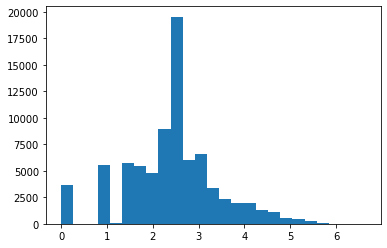

In [12]:
dist_mat = dist_df.to_numpy()
dist_arr = np.array([])
for i in range(len(dist_mat)):
    for j in range(i+1,len(dist_mat)):
        dist_arr = np.append(dist_arr, dist_mat[i][j])
plt.hist(dist_arr, bins = 25)
plt.show

In [13]:
X = np.empty((0,flusso.N_impianti**2), int)
X_log = np.empty((0,flusso.N_impianti**2), int)
X_norm = np.empty((0,flusso.N_impianti**2), int)
for skier_id in flusso.skier_id_set:
    fm_unrolled = flusso.flow_matrices[skier_id].to_numpy().ravel()
    X = np.append(X, [fm_unrolled], axis = 0)
    X_log = np.append(X_log, [np.log(fm_unrolled+1)], axis = 0)
    X_norm = np.append(X_norm, [fm_unrolled/np.max(fm_unrolled)], axis = 0)

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_7967/1469418689.py:8: RuntimeWarning: invalid value encountered in true_divide
  X_norm = np.append(X_norm, [fm_unrolled/np.max(fm_unrolled)], axis = 0)


In [14]:
U,s,VT=LA.svd(X)
U_log,s_log,VT_log = LA.svd(X_log)

In [18]:
N_CLUSTERS = 12
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(X)
kmeans_log = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(X_log)
#kmeans_norm = KMeans(n_clusters=12, random_state=0).fit(X_norm)
centroids = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans.cluster_centers_]
centroids_log = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans_log.cluster_centers_]
#centroids_norm = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans_norm.cluster_centers_]

In [16]:
def centroids_as_flow_mat(cent_list):
    flow_mat_list = []
    for c in cent_list:
        c_trunc = np.trunc(c*10)/10
        c_flow_matrix = pd.DataFrame(data = c_trunc, columns = flusso.impianto_set)
        c_flow_matrix['ind'] = flusso.impianto_set #flusso needs to be parameterized
        c_flow_matrix.set_index('ind', inplace = True, drop = True)
        flow_mat_list.append(c_flow_matrix)
    return flow_mat_list

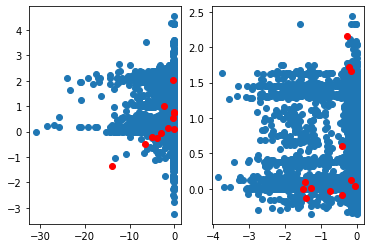

In [24]:
SAMPLE_SIZE = flusso.N_sciatori

x = [np.dot(x_i, VT[0]) for x_i in X]
y = [np.dot(x_i, VT[1]) for x_i in X]

x_log = [np.dot(x_i, VT[0]) for x_i in X_log]
y_log = [np.dot(x_i, VT[1]) for x_i in X_log]

plt.subplot(1,2,1)
plt.scatter(x = random.sample(x,SAMPLE_SIZE), y = random.sample(y,SAMPLE_SIZE))
for c in centroids:
    plt.scatter( np.dot(c.ravel(), VT[0]), np.dot(c.ravel(), VT[1]), c = 'r')

plt.subplot(1,2,2)
plt.scatter(x = random.sample(x_log,SAMPLE_SIZE), y = random.sample(y_log,SAMPLE_SIZE))
for c in centroids_log:
    plt.scatter( np.dot(c.ravel(), VT_log[0]), np.dot(c.ravel(), VT_log[1]), c = 'r')

plt.show()

In [25]:
def plot_impianti(ax = None):
    for row in flussi.impianti_df.iterrows():
        lat_start  = row[1]['Latitude Start']
        long_start = row[1]['Longitude Start']
        lat_end    = row[1]['Latitude End']
        long_end   = row[1]['Longitude End']
        
        mid_lat = np.mean([lat_start, lat_end])
        mid_long = np.mean([long_start, long_end])
        
        geometry = LineString([(long_start, lat_start),(long_end, lat_end)])
        gdf = gpd.GeoDataFrame(geometry=[geometry])
        ax = gdf.plot(ax = ax, lw = 2.5, color='k')
        #ax = gdf.plot(lw = 2.5, color='k')
        ax.text(s=row[1]['Nome'],x = mid_long, y = mid_lat)
    return ax

def plot_flow_matrix(flow_matrix, kmeans = None, ax = None, cent_i = None, pre_plot_impianti = None):
    max_flow = flow_matrix.max().max()
    
    if pre_plot_impianti:
        ax = pre_plot_impianti
    else:
        ax = plot_impianti(ax)
    idf = flussi.impianti_df

    THRESH = 0.0
    THICKNESS_FACTOR = 10
    geometry = np.empty((len(flow_matrix)**2,), np.dtype(LineString))
    thickness = np.zeros(len(flow_matrix)**2)
    lw = np.empty((len(flow_matrix)**2,), np.dtype(LineString))

    k = 0

    for i in flow_matrix:
        for j in flow_matrix:
            if flow_matrix[i][j]/max_flow < THRESH:
                continue

            row_i = idf[idf['Codice'] == i]
            row_j = idf[idf['Codice'] == j]

            lat_start  = float(row_i['Latitude Start'])
            long_start = float(row_i['Longitude Start'])
            lat_end    = float(row_j['Latitude End'])
            long_end   = float(row_j['Longitude End'])
            
            geometry[k] = LineString([(long_start, lat_start),(long_end, lat_end)])
            thickness[k] = THICKNESS_FACTOR*flow_matrix[i][j]/max_flow
            k+=1

    gdf = gpd.GeoDataFrame(geometry=geometry)
    gdf['thickness'] = thickness
    ax = gdf.plot(ax = ax, lw = gdf['thickness'], color='r', alpha = 0.5) 
    
    if cent_i != None:
        n_in_cent = Counter(kmeans.labels_)[cent_i]
        ax.set_title(f'Plot {cent_i}: Max = {max_flow}, n = {n_in_cent}', fontsize = 18)
            
            
def plot_centroids(kmeans, centroids):
    len_cent = len(centroids)

    fig = plt.figure(figsize=(20,4*len_cent))
    gs = gridspec.GridSpec(ncols = 2, nrows = len_cent, width_ratios=(2,1))

    last_ax2 = None
    BINS = np.arange(-1,2,0.25)

    plot_impianti()

    for i, cent in enumerate(centroids):
        ax = fig.add_subplot(gs[2*i])

        plot_flow_matrix(cent, kmeans, ax, i)

        ax2 = fig.add_subplot(gs[2*i+1])
        
        dists = LA.norm(X[kmeans.labels_ == i] - kmeans.cluster_centers_[i], axis = 1)
        ax2.hist(np.log10(dists),bins=BINS)

        last_ax2 = ax2

    fig.suptitle('K-Means Centroids', fontsize = 28, y=0.9)
    plt.show()

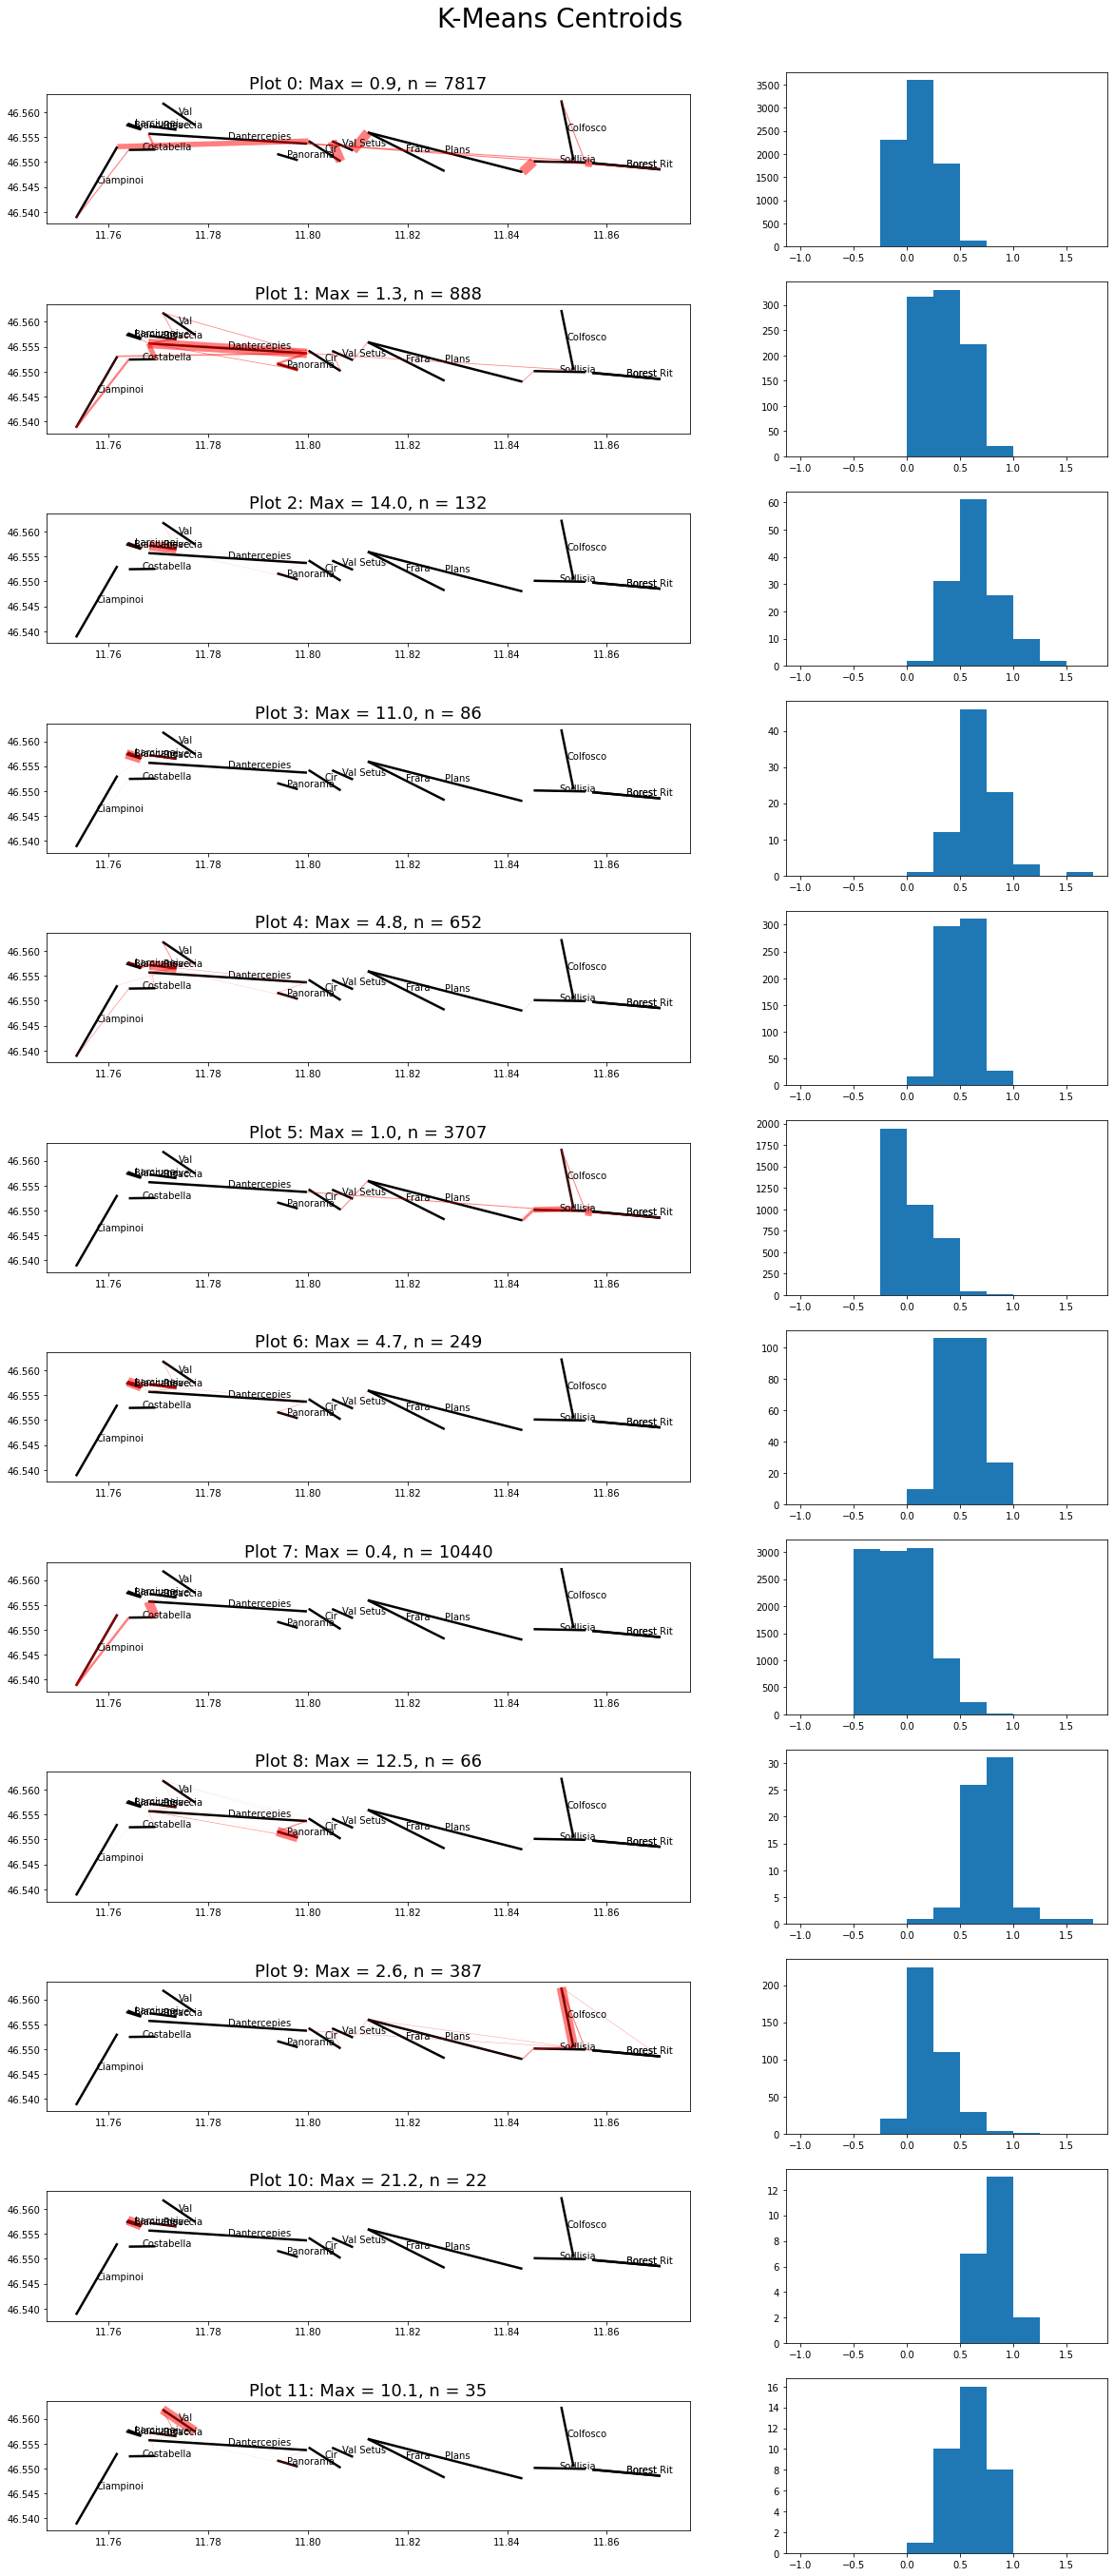

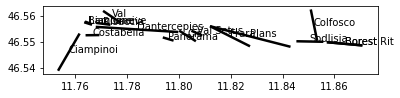

In [26]:
plot_centroids(kmeans, centroids_as_flow_mat(centroids))

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_7967/2643617700.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if flow_matrix[i][j]/max_flow < THRESH:
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_7967/2643617700.py:49: RuntimeWarning: invalid value encountered in double_scalars
  thickness[k] = THICKNESS_FACTOR*flow_matrix[i][j]/max_flow
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_7967/2643617700.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if flow_matrix[i][j]/max_flow < THRESH:
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_7967/2643617700.py:49: RuntimeWarning: invalid value encountered in double_scalars
  thickness[k] = THICKNESS_FACTOR*flow_matrix[i][j]/max_flow
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_7967/2643617700.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if flow_matrix[i][j]/max_flow < THRESH:
/var/folders/21/flqpgr7x45s3tfyly7hcxr4000

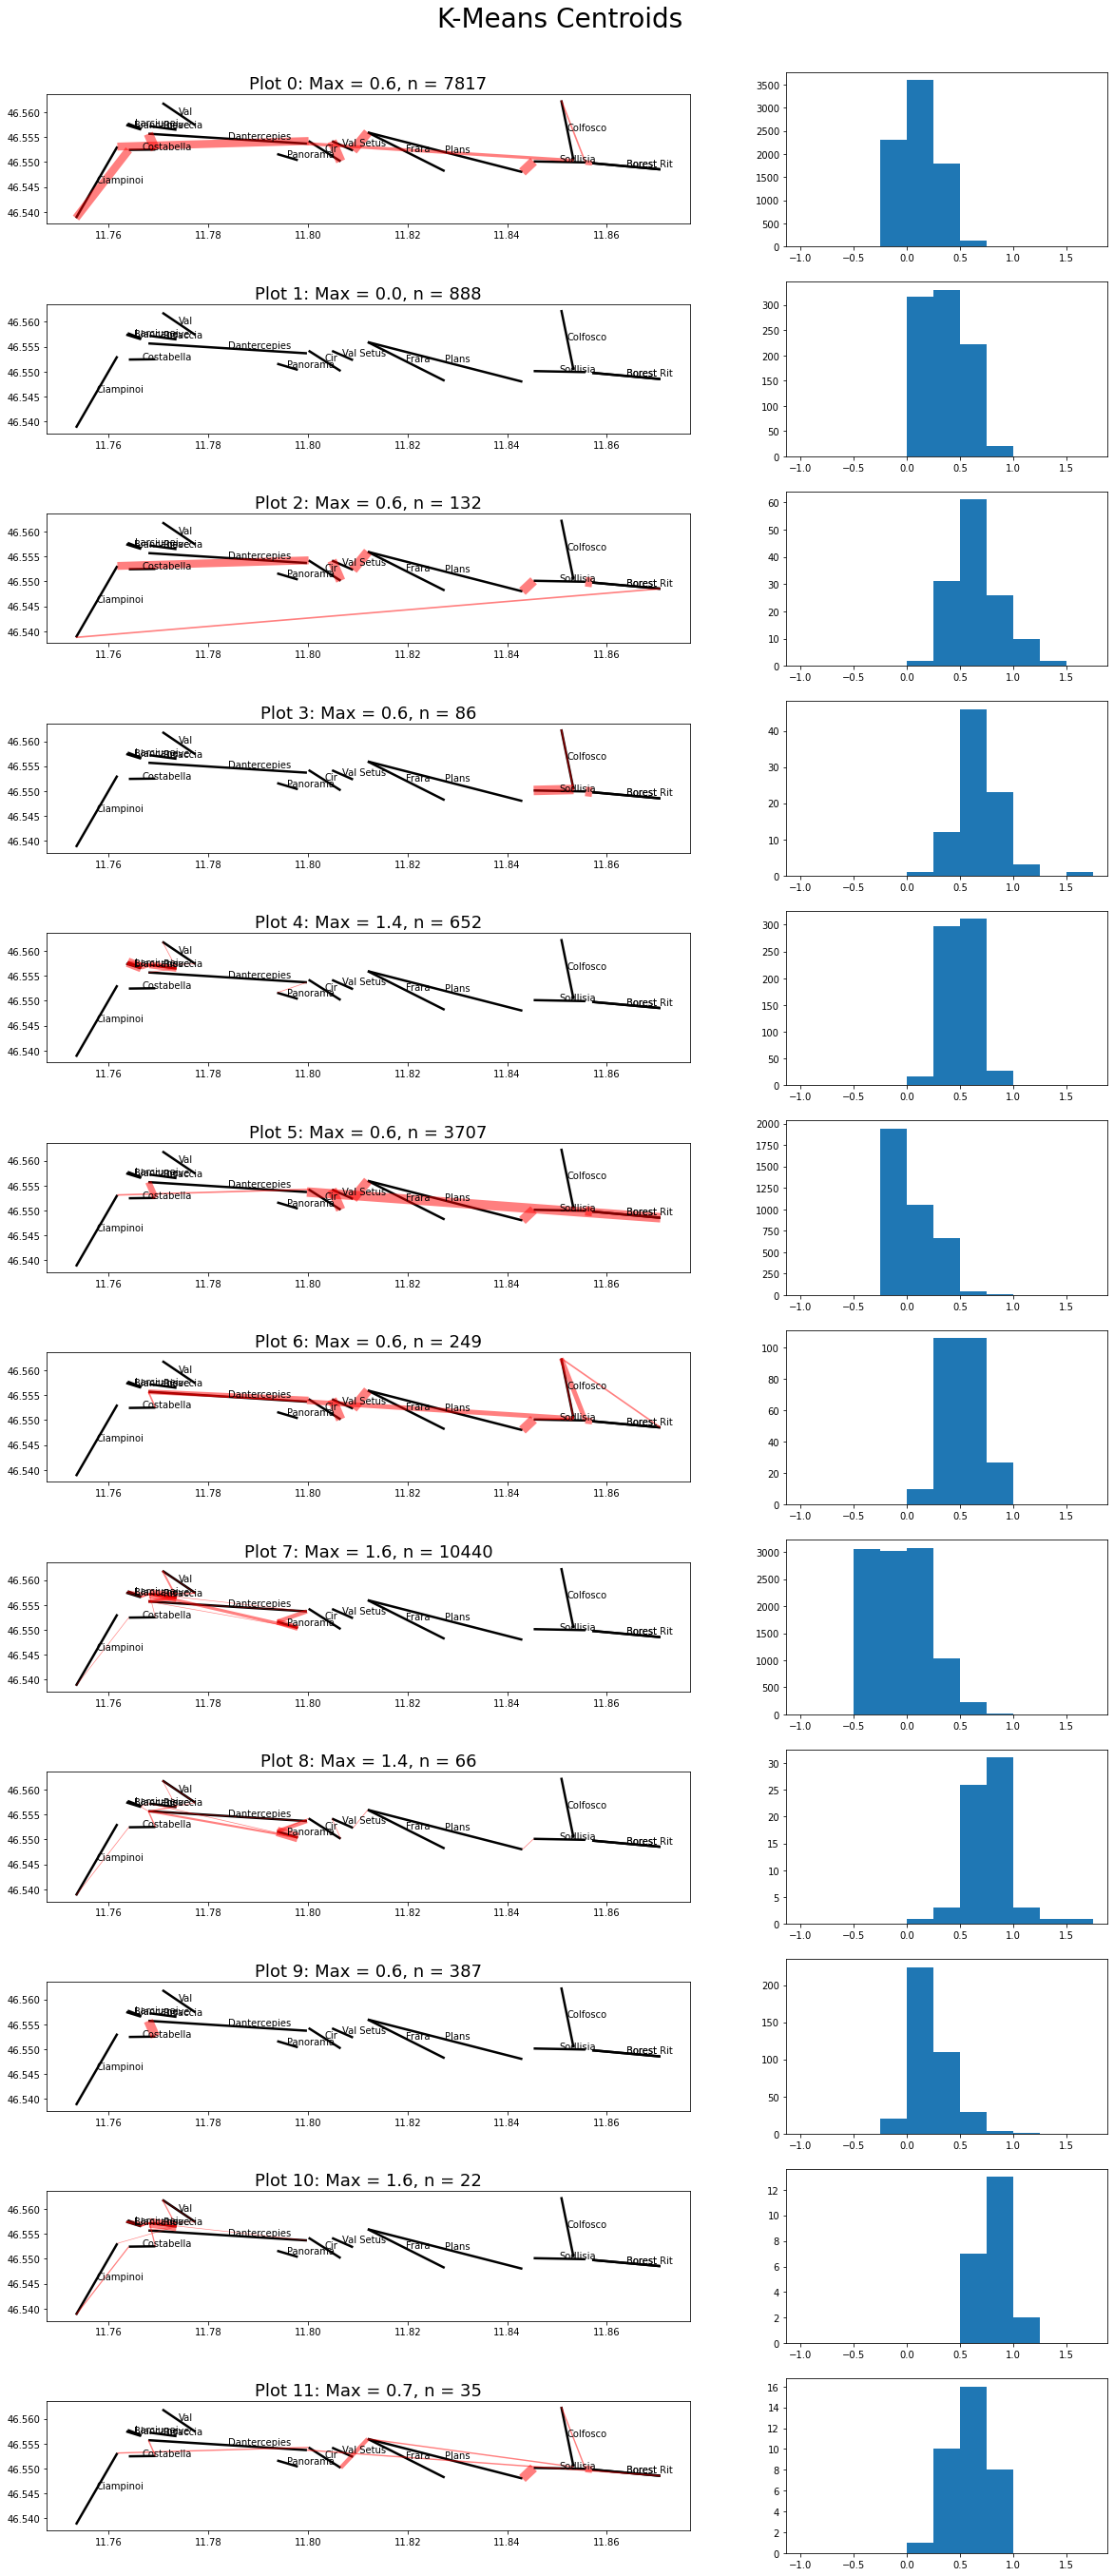

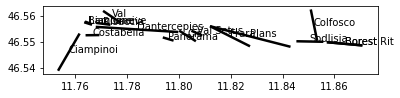

In [27]:
plot_centroids(kmeans, centroids_as_flow_mat(centroids_log))

In [ ]:
anti_01_03 = pd.read_excel('rasom_sella_ronda/SensoAntiorario-2006-01-03.xls')
anti_01_03_skier_id_set = list(set(anti_01_03['SKIER_ID']))
anti_01_03_skier_id_set

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


[32768,
 1,
 3,
 4,
 5,
 9,
 32781,
 32782,
 32783,
 32784,
 32785,
 32788,
 32789,
 32790,
 32791,
 24,
 32793,
 32792,
 32795,
 32796,
 32794,
 32799,
 32800,
 33,
 34,
 32802,
 32801,
 35,
 38,
 32807,
 32808,
 32809,
 65575,
 65577,
 40,
 44,
 46,
 13035,
 48,
 65596,
 13038,
 13039,
 32839,
 32840,
 32841,
 32842,
 65607,
 32843,
 32845,
 32844,
 32847,
 32848,
 32846,
 32849,
 32852,
 32853,
 32855,
 32856,
 32858,
 32865,
 32867,
 32868,
 32869,
 32870,
 32871,
 32872,
 32877,
 32878,
 32879,
 32880,
 32881,
 32882,
 32883,
 32884,
 65653,
 32885,
 65655,
 32888,
 32889,
 65657,
 65658,
 32887,
 32890,
 32895,
 32898,
 32899,
 32902,
 32903,
 32904,
 32905,
 32906,
 32908,
 32909,
 32910,
 32911,
 32912,
 32915,
 32918,
 32919,
 32920,
 65699,
 65700,
 65701,
 32934,
 32935,
 13059,
 32937,
 32936,
 32939,
 32938,
 13060,
 174,
 175,
 173,
 32943,
 32942,
 32944,
 32949,
 36,
 32955,
 65724,
 37,
 65726,
 32958,
 32961,
 32962,
 32963,
 32964,
 65735,
 65736,
 65737,
 65738,
 20

In [ ]:
print(flusso.file_name)

01-03-2006-SelvaColfosco


In [ ]:
len(flusso.df[flusso.df['SERIE'].isin(anti_01_03_serie_set)])

31431

In [ ]:
len(flusso.df)

128680

In [ ]:
set(anti_01_03['IMPIANTO'])

{163,
 175,
 177,
 180,
 182,
 220,
 232,
 233,
 236,
 240,
 245,
 301,
 303,
 392,
 714,
 715}

In [ ]:
fluss_anti_01_03 = flussi('rasom_sella_ronda/SensoAntiorario-2006-01-03.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
{163, 392, 232, 714, 715, 236, 301, 233, 175, 240, 177, 303, 180, 245, 182, 220}
No column ID_LETTORE for file rasom_sella_ronda/SensoAntiorario-2006-01-03.xls


3648.0


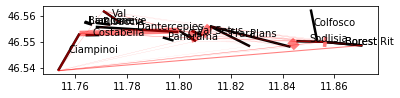

In [ ]:
print(fluss_anti_01_03.flow_matrix.max().max())
plot_flow_matrix(fluss_anti_01_03.flow_matrix)

In [ ]:
for i in range(len(centroids)):
    kmeans_anti = np.array(list(flusso.flow_matrices.keys()))[kmeans.labels_ == i]
    kmeans_anti_in_giov_anti = [f for f in kmeans_anti if f in fluss_anti_01_03.serie_set]
    giov_anti_in_kmeans_anti = [f for f in fluss_anti_01_03.serie_set if f in kmeans_anti]
    print(i, len(kmeans_anti_in_giov_anti)/len(kmeans_anti), len(giov_anti_in_kmeans_anti)/len(fluss_anti_01_03.serie_set))

0 0.14417744916820702 0.06606170598911071
1 0.1875 0.003629764065335753
2 0.13522215067611076 0.07622504537205081
3 0.1509207365892714 0.0456140350877193
4 0.13056234718826407 0.032304900181488204
5 0.11869436201780416 0.009679370840895343
6 0.13289581624282198 0.07840290381125227
7 0.17647058823529413 0.001088929219600726
8 0.25806451612903225 0.0009679370840895341
9 0.125 0.0012099213551119178
10 0.23076923076923078 0.0007259528130671506
11 0.15422885572139303 0.003750756200846945


In [36]:
TIME_INTERVAL = 3600
START_TIME = 7
START_TIME_DT = dt.datetime(year = int(flusso.date[-4:]), month = int(flusso.date[3:5]), day = int(flusso.date[:2]), hour = START_TIME)
START_TIME_SECONDS = START_TIME*3600
END_TIME = 18
END_TIME_DT = dt.datetime(year = int(flusso.date[-4:]), month = int(flusso.date[3:5]), day = int(flusso.date[:2]), hour = END_TIME)
END_TIME_SECONDS = END_TIME*3600
MIDNIGHT = dt.datetime(year = int(flusso.date[-4:]), month = int(flusso.date[3:5]), day = int(flusso.date[:2]))

times_df = pd.DataFrame(columns = np.arange(START_TIME, END_TIME, TIME_INTERVAL / 3600))
#global_links = {}
#global_links_norm = {}

links_raw = {}
links_norm = {}

for s in flusso.skier_id_set[:1000]: # GET RID OF :10!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ski_day = flusso.df[flusso.df['SKIER_ID'] == s].sort_values('DATA_ORA')
    #links = {}
    #print(ski_day[['DATA_ORA', 'ID_IMPIANTO']])
    for i,row in enumerate(ski_day[:-1].iterrows()):
        origin = ski_day.iloc[i]['ID_IMPIANTO']
        dest = ski_day.iloc[i+1]['ID_IMPIANTO']
        time = (ski_day.iloc[i+1]['DATA_ORA'].to_pydatetime() - MIDNIGHT).total_seconds()
        time_delt = (ski_day.iloc[i+1]['DATA_ORA'].to_pydatetime() - ski_day.iloc[i]['DATA_ORA'].to_pydatetime()).total_seconds()

        if time_delt < 60:
            print(s)

        if dest not in links_raw.keys():
            links_raw[dest] = pd.DataFrame(columns = np.arange(START_TIME, END_TIME, TIME_INTERVAL / 3600))
        
        if origin not in links_raw[dest].index:
            #arr = np.zeros(int(END_TIME_SECONDS//TIME_INTERVAL - START_TIME_SECONDS//TIME_INTERVAL))
            df = links_raw[dest]
            empty_row = [np.array([]) for _ in df.columns]
            df.loc[origin] = empty_row
        
        #links[dest].loc[origin].iloc[int((time//TIME_INTERVAL) - (START_TIME*3600//TIME_INTERVAL))] = time_delt
        col_iloc = int((time//TIME_INTERVAL) - (START_TIME*3600//TIME_INTERVAL))
        arr = links_raw[dest].loc[origin].iloc[col_iloc]
        arr = np.append(arr, time_delt)
        if len(arr) == 1:
            links_raw[dest].loc[origin].iloc[col_iloc] = [arr]
        else:
            links_raw[dest].loc[origin].iloc[col_iloc] = arr


'''

    #links_norm = {}
    for i, (dest, df) in enumerate(links.items()):
        df_norm = df.div(df.max(axis = 1), axis = 0)
        links_norm[dest] = df_norm

        if dest not in times_df.index:
            continue
        
        if dest not in global_links.keys():
            global_links[dest] = pd.DataFrame(columns = np.arange(START_TIME, END_TIME, TIME_INTERVAL / 3600))'''

                                                                                                                                                                    
links[221]

1005
1005
2005
2005
17960097
35131092
4005
    7.0  8.0  9.0         10.0 11.0  \
221   []   []   []  [[4440.0]]   []   
220   []   []   []          []   []   
186   []   []   []  [[4260.0]]   []   
177   []   []   []          []   []   
180   []   []   []          []   []   
392   []   []   []    [[60.0]]   []   
175   []   []   []          []   []   

                                                  12.0  \
221                  [4740.0, 8040.0, 13560.0, 7440.0]   
220  [13260.0, 11580.0, 11160.0, 11340.0, 11400.0, ...   
186                  [9840.0, 6960.0, 9840.0, 10800.0]   
177                                   [7440.0, 7440.0]   
180                                                 []   
392                                                 []   
175                                                 []   

                                                  13.0  \
221  [13620.0, 4920.0, 14040.0, 9240.0, 12180.0, 14...   
220                                        [[12360.0]]   
186  

ValueError: operands could not be broadcast together with shapes (4,) (0,) 

In [41]:
for i, (dest, df) in enumerate(links_raw.items()):
    print(df)
    df.applymap(func = lambda arr : [np.percentile(arr, 10)])

    7.0  8.0  9.0         10.0 11.0  \
221   []   []   []  [[4440.0]]   []   
220   []   []   []          []   []   
186   []   []   []  [[4260.0]]   []   
177   []   []   []          []   []   
180   []   []   []          []   []   
392   []   []   []    [[60.0]]   []   
175   []   []   []          []   []   

                                                  12.0  \
221                  [4740.0, 8040.0, 13560.0, 7440.0]   
220  [13260.0, 11580.0, 11160.0, 11340.0, 11400.0, ...   
186                  [9840.0, 6960.0, 9840.0, 10800.0]   
177                                   [7440.0, 7440.0]   
180                                                 []   
392                                                 []   
175                                                 []   

                                                  13.0  \
221  [13620.0, 4920.0, 14040.0, 9240.0, 12180.0, 14...   
220                                        [[12360.0]]   
186  [11100.0, 14460.0, 9420.0, 14460.0, 14460.0

IndexError: ('cannot do a non-empty take from an empty axes.', 'occurred at index 7.0')

In [ ]:
a = pd.DataFrame(data = {0:[1], 1:[2], 2:[3]})
a.loc[1] = [4,5,6]
a.loc[0][1], a

(2,
    0  1  2
 0  1  2  3
 1  4  5  6)

In [33]:
a = pd.DataFrame(columns = [0,1,2])

a.loc[0] = [np.array([]) for _ in a.columns]
arr = a[0].loc[0]
print(type(arr))
arr = np.append(arr, 1)
if len(arr) == 1:
    a[0].loc[0] = [arr]
else:
    a[0].loc[0] = arr

arr = a[0].loc[0]
print(type(arr))
arr = np.append(arr, 1)
if len(arr) == 1:
    a[0].loc[0] = [arr[0]]
else:
    a[0].loc[0] = arr
    arr = a[0].loc[0]

arr = a[0].loc[0]
print(type(arr))
arr = np.append(arr, 1)
if len(arr) == 1:
    a[0].loc[0] = [arr[0]]
else:
    a[0].loc[0] = arr
a[0].loc[0] = 57
a


<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


,0,1,2
0,57,[],[]


In [44]:
flusso.df[:10]

,CASSA,SERIE,DATA_ORA,POOL,ID_IMPIANTO,ID_LETTORE,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE,GEO START,GEO END,SKIER_ID
0,91,82237,2006-03-01 08:18:00,1,175,4,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),82237091
1,91,82239,2006-03-01 08:18:00,1,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),82239091
2,91,82241,2006-03-01 08:21:00,1,175,1,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),82241091
3,73,26551,2006-03-01 08:29:00,1,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),26551073
4,91,83584,2006-03-01 08:30:00,1,175,1,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),83584091
5,73,26553,2006-03-01 08:30:00,1,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),26553073
6,113,8538,2006-03-01 08:39:00,1,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),8538113
7,74,85557,2006-03-01 08:39:00,311,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),85557074
8,74,85559,2006-03-01 08:40:00,311,175,4,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),85559074
9,74,85558,2006-03-01 08:40:00,311,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),85558074


In [ ]:
flussi.impianti_df

In [ ]:
def last_run_before_time(imp_entrances, time):
    '''
    Finds last entrance in IMP_ENTRANCES before TIME.
    
    parameters:
    IMP_ENTRANCES: a dataframe of a specific skiers entrances onto a specific lift
             TIME: the threshold time
             
    returns:
        I: The index of the last entrance in IMP_ENTRANCES before TIME
    DELTA: The time difference between the desired entrance and TIME
    '''
    delta = dt.timedelta(0)
    t = imp_entrances['DATA_ORA'].iloc[0]
    i = 0
    while t < time and i < len(imp_entrances) - 1:
        i+=1
        delta = time - t
        t = imp_entrances['DATA_ORA'].iloc[i]
    return i, delta

def sellar_anti_class(day, inter_ids):
    '''
    Tries to find skiers who are on the anticlockwise sellaronda on day with index DAY, by examining time
    delta between skiers entrances onto Borest and Ciampinoi. Returns number of rides on lifts given by
    INTER_IDS between Borest and Ciampinoi.
    
    parameters:
          DAY: The index of the day to be analyzed in DATASET_LIST
    INTER_IDS: ID_IMPIANTO of the lifts whose intermediate rides should be counted
    
    returns:
    
    '''
    flusso = dataset_list[day]
    df = flusso.df

    delta_arr = np.array([])
    num_danter_arr = np.array([])
    
    inter_counts = {}
    for inter_id in inter_ids:
        inter_counts[inter_id] = np.array([])

    k=0
    for s in flusso.serie_set:
        if k % 1000 == 0:
            print(k, '/', len(flusso.serie_set))
        k+=1

        ski_day = df[df['SERIE'] == s]
        borest = ski_day[ski_day['ID_IMPIANTO'] == 175]
        ciampi = ski_day[ski_day['ID_IMPIANTO'] == 220]
        
        danter = ski_day[ski_day['ID_IMPIANTO'] == 221]
        cir = ski_day[ski_day['ID_IMPIANTO'] == 232]

        if len(borest) == 0 or len(ciampi) == 0:
            continue

        i, delta = last_run_before_time(borest, ciampi['DATA_ORA'].iloc[0])
        last_borest_time = borest['DATA_ORA'].iloc[i]

        if delta == dt.timedelta(0):
            continue

        def num_inter_runs(inter_id):
            inter_all = ski_day[ski_day['ID_IMPIANTO'] == inter]
            inter_lower = inter_all[inter_all['DATA_ORA'] > last_borest_time]
            inter = inter_lower[inter_lower['DATA_ORA'] < ciampi['DATA_ORA'].iloc[0]]
            return inter
        
        for inter_id in inter_ids:
            ic_arr = inter_counts[inter_id]
            ic_arr = np.append(ic_arr, num_inter_runs(inter_id))

        delta = delta.total_seconds()//60

        delta_arr = np.append(delta_arr, delta)
        
        return delta_arr, 

In [ ]:
plt.hist(num_danter_arr[num_danter_arr>0])
plt.show()

In [ ]:
flusso = dataset_list[6]
df = flusso.df
df['DATA_ORA'][0] - df['DATA_ORA'][120449] > dt.timedelta(0)

In [ ]:
def create_date_range(date_times, is_set = False):
    '''
    parameters:
    DATE_TIMES: Series or set of datetimes
    IS_SET: set to True if DATE_TIMES is a set
    
    return value: a list of datetimes ranging from 
    the earliest to the latest time in DATE_TIMES
    with frequency of one minute
    '''
    if not is_set:
        dt_set = set(date_times)
    else:
        dt_set = date_times
    return pd.date_range(min(dt_set), max(dt_set), freq = 'T')

def skier_path_matrix(flusso, num_skiers = None):
    #TEMP:
    #day_frame = day_frame[day_frame['SERIE'] == 33022]
    day_frame = flusso.df
    if num_skiers:
        day_frame = flusso.df[flusso.df['SERIE'] == random.sample(flusso.serie_set, num_skiers)]
    
    serie = day_frame['SERIE']
    serie_set = list(set(serie))
    data_ora = day_frame['DATA_ORA']
    data_ora_set = set(data_ora)
    impianti = day_frame['ID_IMPIANTO']
    
    dr = create_date_range(data_ora_set, is_set = True)
    
    matrix = pd.DataFrame(columns = dr)
    matrix_norm = pd.DataFrame(columns = np.arange(len(dr)))
    
    k = 0
    max_day = 0
    for skier in serie_set:
        k+=1
        if k%1000 == 0:
            print(f'{k}/{len(serie_set)}')
        ski_day = day_frame[serie == skier].sort_values('DATA_ORA')
        ski_day_ore = ski_day['DATA_ORA']
        
        #print(ski_day)
        
        td_init = int((ski_day_ore.iloc[0] - dr[0]).total_seconds()/60)
        impianti_skier = np.array(np.zeros(td_init))
            
        i=-1
        day_len = 0
        for i in range(len(ski_day) - 1):
            td = int((ski_day_ore.iloc[i+1] - ski_day_ore.iloc[i]).total_seconds()/60)
            to_add = np.full(shape = td, fill_value = ski_day['ID_IMPIANTO'].iloc[i])
            impianti_skier = np.append(impianti_skier, to_add)
            
            day_len += td
        
        if day_len > max_day:
            max_day = day_len
            max_skier = skier
        
        #print(f'len diff: {len(dr) - len(impianti_skier)}, i: {i}, skier: {skier}')
        
        impianti_skier_norm = impianti_skier[td_init:]
        
        fv = ski_day['ID_IMPIANTO'].iloc[i+1]
        fill_norm = np.full(shape = len(dr) - len(impianti_skier_norm), fill_value = fv)
        fill = fill_norm[td_init:]
        
        impianti_skier_norm = np.append(impianti_skier_norm, fill_norm)
        #print(len(impianti_skier_norm), impianti_skier_norm)
        impianti_skier = np.append(impianti_skier, fill)

        matrix.loc[skier] = impianti_skier
        matrix_norm.loc[skier] = impianti_skier_norm
        
    return matrix, matrix_norm

In [ ]:
def skier_path_matrix_latlong(day_frame, num_skiers):
    day_frame = flusso.df
    if num_skiers:
        day_frame = flusso.df[flusso.df['SERIE'].isin(random.sample(flusso.serie_set, num_skiers))]
    
    serie = day_frame['SERIE']
    serie_set = list(set(serie))
    data_ora = day_frame['DATA_ORA']
    data_ora_set = set(data_ora)
    impianti = day_frame['ID_IMPIANTO']
    
    dr = create_date_range(data_ora_set, is_set = True)
    
    matrix = pd.DataFrame(columns = [dr,dr])
    #matrix_norm = pd.DataFrame(columns = np.arange(len(dr)))
    
    k = 0
    max_day = 0
    for skier in serie_set:
        print(skier)
    return matrix
        

In [ ]:
skier_path_matrix_latlong(dataset_list[6].df, 100)

In [ ]:
x = skier_path_matrix(dataset_list[6].df, 100)[0]

In [ ]:
spm = x
a,b=0,0
for i in spm.iterrows():
    for j in spm.iterrows():
        dist = 0
        for k in range(len(i[1])):
            i_pos = get_pos(i[1].iloc[k])
            j_pos = get_pos(j[1].iloc[k])
            dist += get_dist(i_pos, j_pos)
                

In [ ]:
flusso = dataset_list[6]

dat = flusso.df[flusso.df['SERIE'].isin(random.sample(flusso.serie_set, 5))]
dat.sort_values('SERIE')

In [ ]:
a=[i for i in [1,2,3] if i in [1,2]]


a

In [ ]:
next(flusso.df.iterrows())[1]['SERIE']